# Working with Probability Distributions

`deeplenstronomy` has several built-in probability distributions directly callable from the configuration file. Sometimes these are enough, and sometimes not. If you find you need more flexibility than the built-in distributions, you can supply any distribution you want as a text file. This notebook will review the standard way of using the built-in distributions and then demonstrate the text file method.

## Using built-in probability distributions

In [1]:
from deeplenstronomy import distributions

%matplotlib notebook

In [2]:
[x for x in dir(distributions) if not x.startswith('_')]

['delta_function',
 'delve_exposure_time',
 'delve_magnitude_zero_point',
 'delve_seeing',
 'delve_sky_brightness',
 'des_ccd_gain',
 'des_exposure_time',
 'des_magnitude_zero_point',
 'des_num_exposures',
 'des_seeing',
 'des_sky_brightness',
 'lognormal',
 'lsst_exposure_time',
 'lsst_magnitude_zero_point',
 'lsst_num_exposures',
 'lsst_seeing',
 'lsst_sky_brightness',
 'normal',
 'np',
 'poisson',
 'poisson_noise',
 'random',
 'symmetric_uniform_annulus',
 'uniform',
 'uniform_int',
 'ztf_magnitude_zero_point',
 'ztf_seeing',
 'ztf_sky_brightness']

The standard way of using one of these distributions is to use the `DISTRIBUTION` keyword within the configuration file. Let's look at a quick example.

In [3]:
import deeplenstronomy.deeplenstronomy as dl

In [4]:
! cat data/demo.yaml

DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 100
        OUTDIR: MySimulationResults

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

IMAGE:
    PARAMETERS:
        exposure_time: 90
        numPix: 100
        pixel_scale: 0.263
        psf_type: 'GAUSSIAN'
        read_noise: 7
        ccd_gain: 6.083

SURVEY:
    PARAMETERS:
        BANDS: g,r,i,z,Y
        seeing: 0.9
        magnitude_zero_point: 30.0
        sky_brightness: 23.5
        num_exposures: 10

SPECIES:
    GALAXY_1:
        NAME: LENS
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 19.5
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        LIGHT_PROFILE_2:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 18.0
                center_x: 0.0
                center_y: 0

At present, all of the parameters are set to constant values. This configuration file offers no variance in the resulting dataset. As an example, let's play with drawing the `exposure_time` and `magnitude` of `GALAXY_2` from distributions.

We'll replace `exposure_time: 90` with
```
exposure_time:
    DISTRIBUTION:
        NAME: uniform
        PARAMETERS:
            minimum: 30.0
            maximum: 300.0
```
to draw the `exposure_time` from a uniform distribution on the interval [30.0, 300.0]. Similarly, we can replace `magnitude: 21.5` with 
```
magnitude:
    DISTRIBUTION:
        NAME: normal
        PARAMETERS:
            mean: 20.0
            std: 1.0
```
to draw the `magnitude` of `GALAXY_2` from a normal distribution with mean 20.0 and standard deviation 1.0.

I have put these update in a new config file called "demo_distributions.yaml", removed configurations 2-4 for efficiency, and increased the number of images to simualte to better characterize the distributions.

In [5]:
! cat data/demo_distributions.yaml

DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 1000
        OUTDIR: MySimulationResults

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

IMAGE:
    PARAMETERS:
        exposure_time:
            DISTRIBUTION:
                NAME: uniform
                PARAMETERS:
                    minimum: 30.0
                    maximum: 300.0
        numPix: 100
        pixel_scale: 0.263
        psf_type: 'GAUSSIAN'
        read_noise: 7
        ccd_gain: 6.083

SURVEY:
    PARAMETERS:
        BANDS: g,r,i,z,Y
        seeing: 0.9
        magnitude_zero_point: 30.0
        sky_brightness: 23.5
        num_exposures: 10

SPECIES:
    GALAXY_1:
        NAME: LENS
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS:
                magnitude: 19.5
                center_x: 0.0
                center_y: 0.0
                R_sersic: 10
                n_sersic: 4
                e1: 0.2
                e2: -0.1
        LIGHT_PROFIL

In [6]:
dataset = dl.make_dataset("data/demo_distributions.yaml", verbose=True)

Entering main organization loop
Organizing CONFIGURATION_1
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 43 S


We can verify that the distributions were used in the data set by inspecting the metadata:

In [7]:
exp_times = dataset.CONFIGURATION_1_metadata['exposure_time-g'].values
magnitudes = dataset.CONFIGURATION_1_metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].values

In [8]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


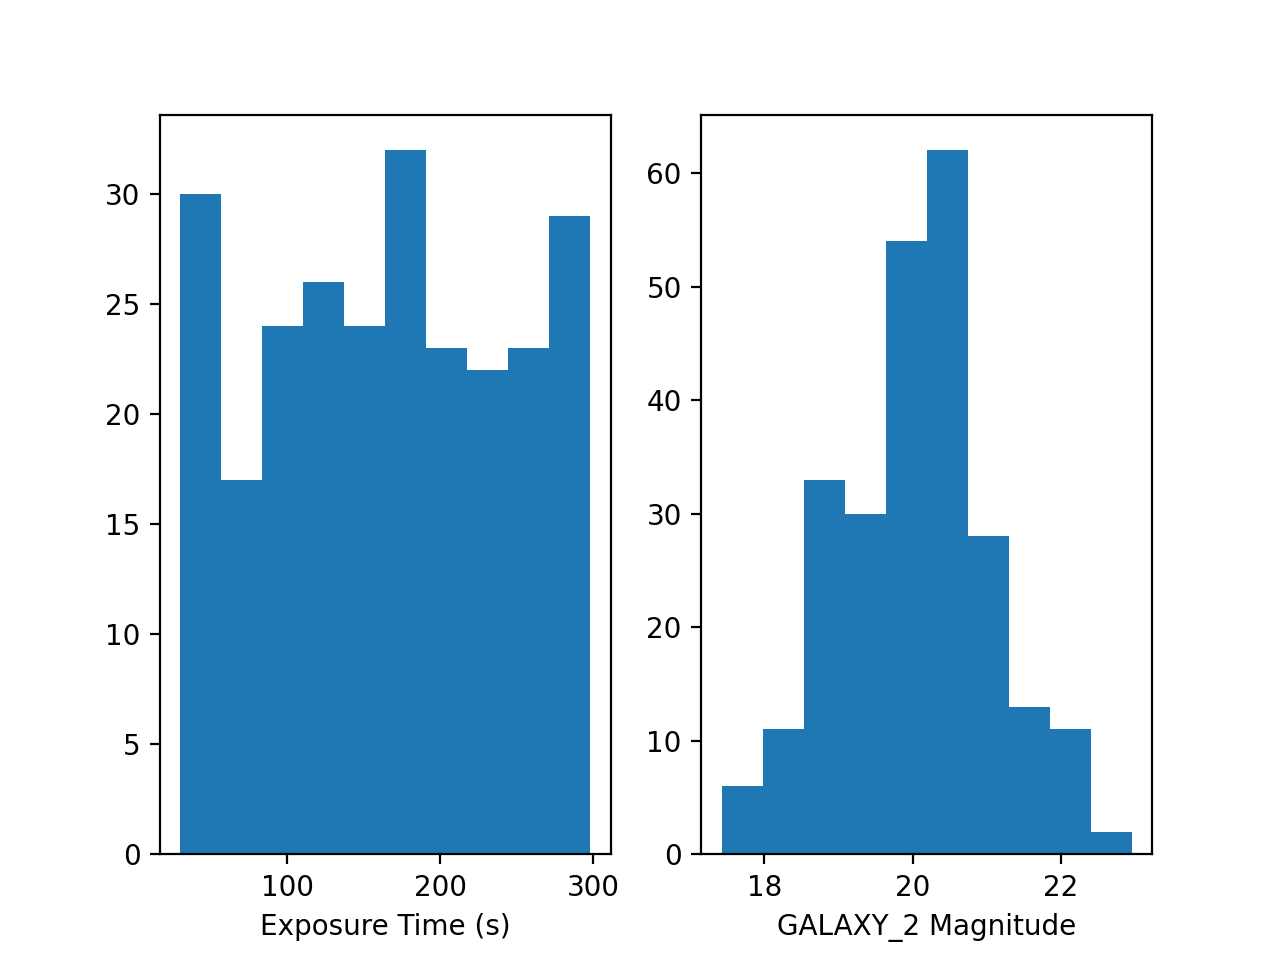

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(exp_times)
ax1.set_xlabel("Exposure Time (s)")

ax2.hist(magnitudes)
ax2.set_xlabel("GALAXY_2 Magnitude")

plt.show()


And we can see the uniform distribution of exposure time and the normal distribution of magnitude have been recovereed. With the exception of a few safe-guarded parameters, any single parameter can be sampled from an underlying built-in distribution using the method above.

## Correlations and Non-Standard Distributions

If you would like to create correlations between parameters or utilize your own empriical distribution in the construction of your dataset, you can make use of `deeplenstronomy`'s `USERDIST` feature. To use this feature, you add an entry to the configuration file that looks like this:

```
DISTRIBUTIONS:
    USERDIST_1:
        FILENAME: data/seeing.txt
        MODE: interpolate
        STEP: 20
    USERDIST_2:
        FILENAME: data/Rsersic_magnitude.txt
        MODE: sample
```

The `DISTRIBUTIONS` section goes a the same level of the yaml file as the `DATASET`, `COSMOLOGY`, `IMAGE` etc. sections. Let's dive into what each of the parts of that entry mean.

`USERDIST_#`

- Each `USERDIST` entry represents an independent probability distribution you want to add into your dataset. They must be indexed as 1, 2, 3, ... for `deeplenstronomy` to track them properly.

`FILENAME`

- This parameter specifies the text file that contains an empirical version of the probability distribution. More details on the structure of this file is available in the next subsection.

`MODE`

- This tells `deeplenstronomy` how you want to use the probability distribution you supplied. The options are `interpolate` and `sample`.

    - `interpolate` will use the points in your distribution to form the basis of a grid that will be sampled during dataset generation.
    
        - `STEP` is only used if you use the `interpolate` mode, and it is the number of points in each dimension of the grid that is sampled. The number of elements in the grid is the value of `STEP` raised to the power of the number of dimensions in your distribution. This can easily exceed the available memory in your computer if you have high-dimensional distributions and a large `STEP` value. If `STEP` is not specified, the default of 10 will be used.
        
    - `sample` will draw only from the raw points specified and not perform any interpolation. This mode is recommended if you have a highly-dimensional distribution with a lot of structure in each dimension for memory considerations.

### Writing probability distribution files

Let's inspect "seeing.txt" to learn how to work with a one-dimensional distribution.

In [10]:
! cat data/seeing.txt

seeing WEIGHT
0.5 0.1
0.6 0.2
0.7 0.25
0.8 0.3
0.9 0.3
1.0 0.25
1.1 0.6
1.2 0.9
1.3 0.2
1.4 0.1


These files are whitespace-separated, use the paramater name as a column header, and specify the probability weight associated with each point in parameter space. The weights are defined relative to each other and do not need to sum to one. There is also no requirement of regular spacing in the distributions, though it may lead to more accurate interpolations.

At present, the supplied seeing distribution will be applied to all bands and all configurations in the dataset. If, for example, we only wanted the distribution to apply to the $g$-band seeing, the column name would be changed to `seeing-g`. If we wanted the distribution to only apply to `CONFIGURATION_1`, then we could use `CONFIGURATION_1-seeing` as the column name. And if we only want to target the $g$ -band seeing in `CONFIGURATION_1`, then we would use `CONFIGURATION_1-seeing-g`.

We can verify this distribution was put into the dataset by plotting the raw text file distribution over the simulated seeing values:

In [11]:
import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>


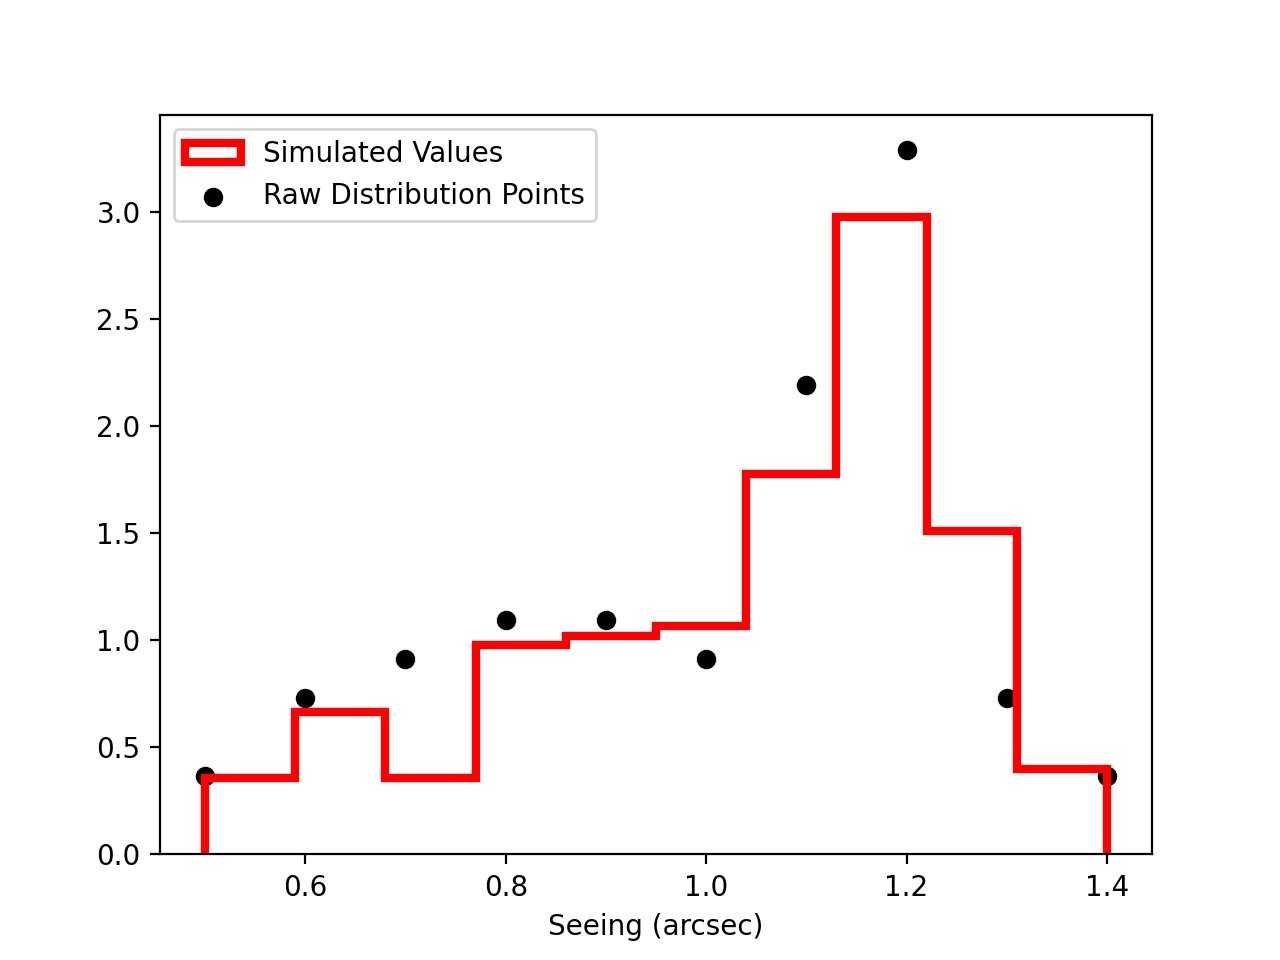

In [12]:
df = pd.read_csv('data/seeing.txt', delim_whitespace=True)
# just normalizing weights to an AUC of 1.0 using a rectangular sum
norm_const = sum((df['seeing'].values.max() - df['seeing'].values.min()) / len(df) * df['WEIGHT'].values.mean() * df['seeing'].values)

plt.figure()
plt.scatter(df['seeing'].values, df['WEIGHT'].values / norm_const, color='black', label='Raw Distribution Points')
plt.hist(dataset.CONFIGURATION_1_metadata['seeing-g'].values, density=True, histtype='step', lw=3, color='red', label="Simulated Values")
plt.xlabel("Seeing (arcsec)")
plt.legend(loc='upper left')
plt.show()

Let's now use this feature to input a correlation, and let's plan to use the `sample` mode instead of the `interpolate` mode.

In [13]:
! head data/Rsersic_magnitude.txt

PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude WEIGHT
0.56 19.25 0.63
1.34 17.26 0.89
1.29 17.65 0.73
2.10 17.02 0.01
0.83 18.33 0.60
2.61 16.00 0.10
0.73 18.84 0.88
0.77 18.79 0.10
0.69 14.78 0.09


Here we're using a distribution in the text file to draw the size of the galaxy measured in the $i$-band (`PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i`) with the magnitude measured in all bands (`PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude`). We'll compare the raw distribution from the text file to the simulated metadata parameters:

In [14]:
df = pd.read_csv('data/Rsersic_magnitude.txt', delim_whitespace=True)

<IPython.core.display.Javascript object>


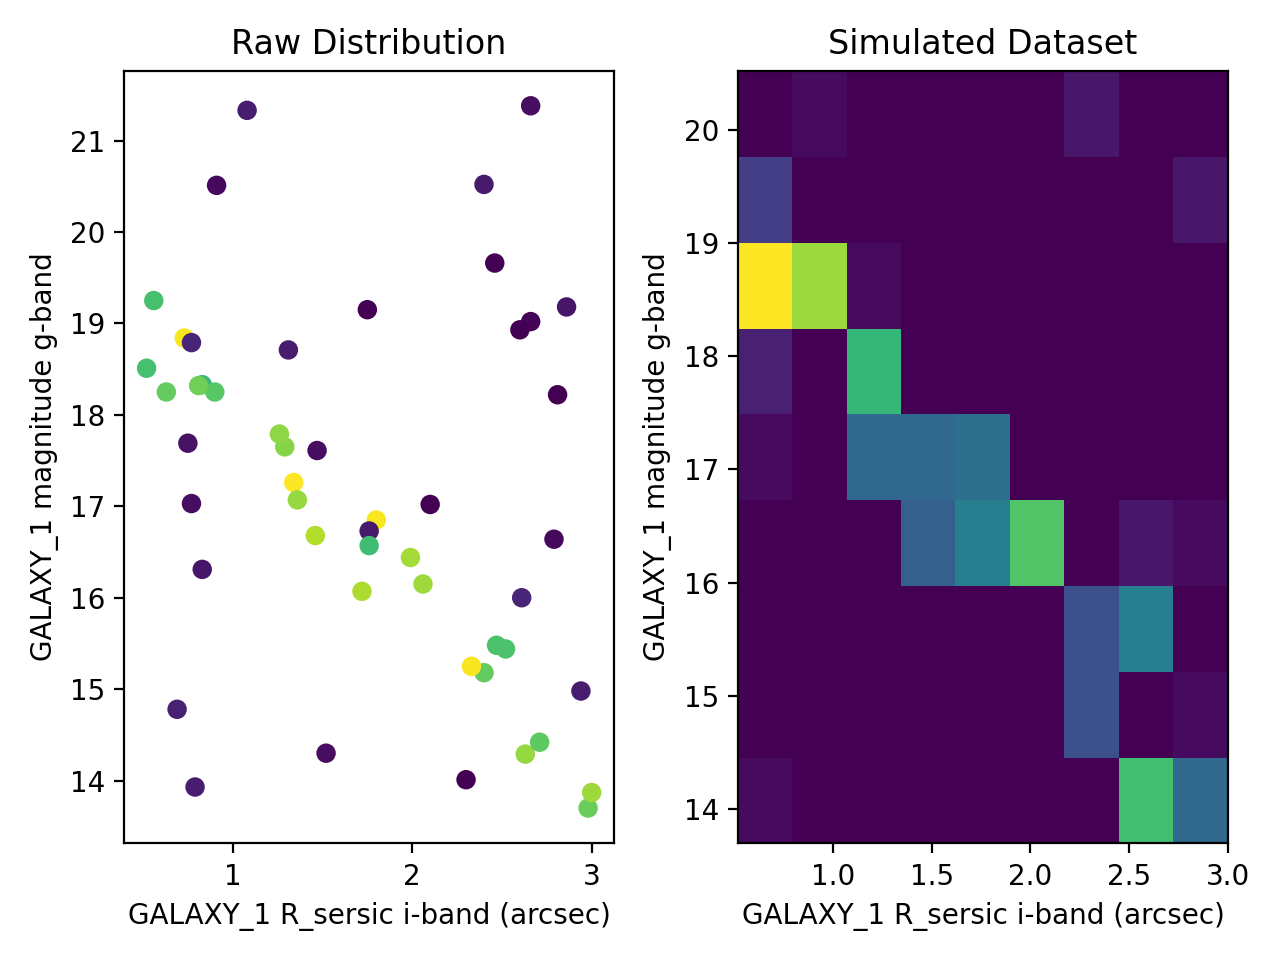

In [15]:
r_sersic = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i'].values
magnitudes = dataset.CONFIGURATION_1_metadata['PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g'].values

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(df['PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i'].values,
            df['PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude'].values,
           c=df['WEIGHT'].values)
ax1.set_xlabel("GALAXY_1 R_sersic i-band (arcsec)")
ax1.set_ylabel("GALAXY_1 magnitude g-band")
ax1.set_title("Raw Distribution")

ax2.hist2d(r_sersic, magnitudes,
           bins=[np.linspace(r_sersic.min(), r_sersic.max(), 10),
                 np.linspace(magnitudes.min(), magnitudes.max(), 10)])
ax2.set_xlabel("GALAXY_1 R_sersic i-band (arcsec)")
ax2.set_ylabel("GALAXY_1 magnitude g-band")
ax2.set_title("Simulated Dataset")

fig.tight_layout()
fig.show()

Notice that in the left plot, points are assigned a color based on the weight in the text file, while in the right plot we have a histogram counting the number of simulated images with a particular parameter value combination.

### How am I supposed to know what to put as the column names in my text files?

Good question. 

The column names are certianly scary to look at, but `deeplenstronomy` has a functionality to help you out. Let's revisit the example of trying to correlate the $g$-band `magnitude` of a galaxy with the $i$-band `R_sersic`. Now that we've simualted a dataset, we can `search` for USERDIST column names:

In [16]:
dataset.search('magnitude')

{'LENS': ['CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-i',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-Y',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-magnitude-g',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-magnitude-r',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-magnitude-i',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-magnitude-z',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-magnitude-Y'],
 'SOURCE': ['CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-i',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-z',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magni

The `dataset.search()` function returns all possible USERDIST column names containing the parameter of interest. The returned object is a dictionary where the keys are the object names in the `SPECIES` section and the values are the possible USERDIST column names.

Looking at the output, and knowing you are concerned with the object named `LENS` would point you directly to the column name `CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g`, where we could leave off the `CONFIGURATION_1` part to apply the USERDIST to all configurations. In this case, there is only one CONFIGURATION, so the prefix doesn't matter.

We can repeat the process for `R_sersic`:

In [17]:
dataset.search('R_sersic')

{'LENS': ['CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-r',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-z',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-Y',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-R_sersic-g',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-R_sersic-r',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-R_sersic-i',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-R_sersic-z',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_2-R_sersic-Y'],
 'SOURCE': ['CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-r',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-i',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-z',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-Y']}